# Comparison of Different Algorithmic Trading Strategies on Tesla Stock Price

### Tawfiq Jawhar
<b>Machine Learning (COMP-652 and ECSE-608)<br>
Fall 2018<br>
McGill University <br><br>
Instructors:<br>
Audrey Durand<br>
Riashat Islam <br></b>

---

## Outline

The moving average strategies showed difficulty detecting a fast change in the price. However, the strategies were not bad in some cases were the price was following a smooth trend. 
In the previous work using Gaussian Mixture Models to cluster the return of prices, we were able to cluster a regime of returns that followed a smooth trend; almost gaussian. We were also able to cluster a regime that had a high volatility. 

We will use the GMM as a risk manager. 
The strategy will be as follow:

```
Fit the GMM on the past 255 days
Predict the cluster of the opening price return of the trading day
IF the prediction is in high volatility cluster THEN
    RISK = TRUE
ELSE RISK = FALSE
IF NOT Invested AND MA is Buy and Not RISK THEN
    BUY
ELSE IF Invested AND MA is Sell THEN
    SELL
ELSE IF Invested AND RISK AND Return of trading day is negative THEN
    SELL
```

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
//to show the full output without scrolling

<IPython.core.display.Javascript object>

In [2]:
## to use zipline magic commands (which is not used in this notebook)
%load_ext zipline
## inline plot
%matplotlib inline

##import libraries
import zipline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('seaborn-darkgrid')
#plt.style.use('bmh')

import pickle
import numpy as np
from zipline.api import (
    order_target_percent, 
    record, 
    symbol, 
    schedule_function, 
    sid,
    date_rules,
    time_rules,
    get_open_orders,
    order_percent,
    order,
    set_benchmark)
from zipline.finance import commission, slippage
from zipline import run_algorithm

## pyfolio was not installed in the docker image (needs updating)
## if you want to use pyfolio to analyze the portfolio
try:
    import pyfolio as pf
except:    
    !pip install pyfolio
    import pyfolio as pf
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
## Technical Analysis Library
from talib import EMA
import sklearn.mixture as mix
RANDOM_STATE = 123

In [3]:
## taken from https://github.com/BlackArbsCEO/mixture_model_trading_public/blob/master/notebooks/02.%20Gaussian%20Mixtures-updated.ipynb
def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE, covariance_type='spherical'):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, 
                      max_iter=max_iter,
                      n_init=100,
                      random_state=RANDOM_STATE,
                      covariance_type=covariance_type)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

We will start with SMA strategy then test ES-MA strategy with GMM Risk Manager. 

In [4]:
## Dictionary to hold environment information.
env = {
    'train': {
        'start_time': pd.to_datetime('2014-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2015-12-31').tz_localize('US/Eastern')
    },
    'test': {
        'start_time': pd.to_datetime('2016-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2017-12-31').tz_localize('US/Eastern')
    },
    'commision': None, #commission.PerShare(cost=.0075, min_trade_cost=1.0)
    'slippage': None, #slippage.VolumeShareSlippage()
    'capital': 100000, #USD
    'stock': 'TSLA',
    'date_rules': date_rules.every_day(),
    'time_rules': time_rules.market_open()
}

In [5]:
## SMA strategy with GMM Risk Manager
## SMA parameters
param = {
    'SMA_short' : 7,
    'SMA_long'  : 22
}

## Zipline strategy implementation
def analyze(context=None, results=None):
    fig = plt.figure(figsize=(10,15))
    ax1 = plt.subplot2grid((6,3),(0,0),colspan=3,rowspan=2)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = plt.subplot2grid((6,3),(2,0),colspan=3,rowspan=2)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if env['stock'] in results and 'sma_long' in results and 'sma_short' in results:
        results[['TSLA', 'sma_long', 'sma_short']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, 'TSLA'],
            '^',
            markersize=10,
            color='m',
            label ='buy',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, 'TSLA'],
            'v',
            markersize=10,
            color='k',
            label='sell',
        )
        ax2.plot(
            results.index[results.buy_prevented],
            results.loc[results.buy_prevented, 'TSLA'],
            'x',
            markersize=10,
            color='C3',
            label='Risky Buy Prevented',
        )
        ax2.plot(
            results.index[results.force_sell],
            results.loc[results.force_sell, 'TSLA'],
            'v',
            markersize=10,
            color='C5',
            label='Force Sell',
        )
        plt.legend(loc=0)
    else:
        msg = env['stock']+' data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))

    ax3 = plt.subplot2grid((6,3),(4,0),colspan=3,rowspan=1)
    ax3.set_ylabel('Sharpe Ratio')
    results.sharpe.plot(ax=ax3)
    bottom, top = ax3.get_ylim()
   
    ax3.set_ylim(-3,top)
    
    ax4 = plt.subplot2grid((6,3),(5,0),colspan=1,rowspan=1)
    ax4.set_ylabel("leverage")
    results.leverage.plot(ax=ax4)
    every_nth = 4
    for n, label in enumerate(ax4.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    ax5 = plt.subplot2grid((6,3),(5,1),colspan=2,rowspan=1)
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    pf.plot_monthly_returns_heatmap(returns,ax=ax5)
    plt.tight_layout()
    plt.show()

    
def initialize(context):
    context.invested = False
    context.asset = symbol(env['stock'])
    context.set_commission(env['commision'])
    context.set_slippage(env['slippage'])
    schedule_function(handle_data_daily, env['date_rules'], env['time_rules'])
    

#Daily price history XXXXXXX
def handle_data_daily(context, data):
    training = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=255, 
        frequency='1d'
    )
    
    ##remove last day
    training = training[:-1]
    returns = np.log(training/training.shift(1)).dropna()
    max_iter = 150 
    _X = returns.values.reshape(-1, 1)

    gmm = make_gmm(2, max_iter,covariance_type='spherical').fit(_X)
    
    ## find which cluster has high volatility
    riskyCluster = 0
    labels = gmm.predict(_X)
    no_returns0=returns[[True if x==0 else False for x in labels]].shape[0]
    no_returns1=returns[[True if x==1 else False for x in labels]].shape[0]
    if no_returns0 > no_returns1:
        riskyCluster = 1

    buy = False
    sell = False
    buy_prevented = False
    force_sell = False

    hist = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=param['SMA_long'], 
        frequency='1d'
    )
    
    hist[param['SMA_long']-1]=data.current(context.asset,'open')

    sma_long = hist.mean()
    sma_short = hist[-param['SMA_short']:].mean()
    returns = np.log(hist/hist.shift(1)).dropna()[-1].reshape(-1, 1)
    ## check cluster
    label = gmm.predict(returns)
    #label1 = gmm.predict(np.log(hist/hist.shift(1)).dropna()[-2].reshape(-1, 1) )
    
    risk = np.isin(riskyCluster, label)

     #If no open orders, balance 100% of portfolio to TSLA & 
     #execute scheduled market order if SMA_short is greater than SMA_long. 
    if sma_short > sma_long and not context.invested and not risk:
        order_percent(context.asset, 1.0)
        context.invested = True
        buy=True
    #If no open orders, short sell 100% of portfolio of TSLA & 
    #execute scheduled market order if SMA_long is greater than SMA_short. 
    elif sma_long > sma_short and context.invested: 
        order_percent(context.asset, -1.0)
        context.invested = False
        sell=True

    elif risk and returns[-1] < 0 and context.invested:
        order_percent(context.asset, -1.0)
        context.invested = False
        force_sell=True
    
    if sma_short > sma_long and not context.invested and risk and not force_sell:
        buy_prevented = True
    #Record results
    record(TSLA=data.current(context.asset, "price"),
           sma_long=sma_long,
           sma_short=sma_short,
           buy=buy,
           sell=sell,
           buy_prevented=buy_prevented,
           force_sell=force_sell)
    record(leverage=context.account.leverage)

    

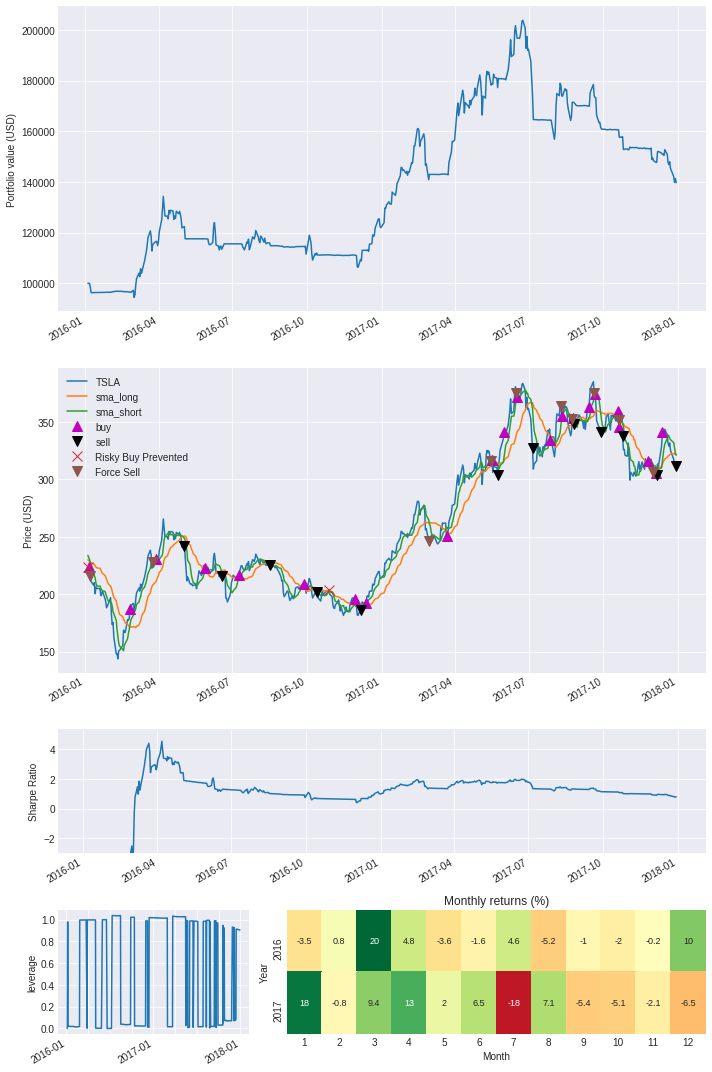

In [6]:
results = run_algorithm(env['test']['start_time'], env['test']['end_time'],
                        initialize=initialize,capital_base=env['capital'], analyze=analyze)
results.to_pickle("results/SMA_GMM.pickle")

Now we will test SE-MA with GMM Risk Manager

In [7]:
## ESMA parameters
param = {
    'SMA_short' : 9,
    'SMA_long'  : 17,
    'EMA_short' : 10,
    'EMA_long'  : 60
}

## Zipline strategy implementation
def analyze(context=None, results=None):
    fig = plt.figure(figsize=(10,15))
    ax1 = plt.subplot2grid((6,3),(0,0),colspan=3,rowspan=2)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = plt.subplot2grid((6,3),(2,0),colspan=3,rowspan=2)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if env['stock'] in results and 'sma_long' in results and 'sma_short' in results:
        results[['TSLA', 'sma_long', 'sma_short']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, 'TSLA'],
            '^',
            markersize=10,
            color='m',
            label ='buy',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, 'TSLA'],
            'v',
            markersize=10,
            color='k',
            label='sell',
        )
        ax2.plot(
            results.index[results.buy_prevented],
            results.loc[results.buy_prevented, 'TSLA'],
            'x',
            markersize=10,
            color='C3',
            label='Risky Buy Prevented',
        )
        ax2.plot(
            results.index[results.force_sell],
            results.loc[results.force_sell, 'TSLA'],
            'v',
            markersize=10,
            color='C5',
            label='Force Sell',
        )
        plt.legend(loc=0)
    else:
        msg = env['stock']+' data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))

    ax3 = plt.subplot2grid((6,3),(4,0),colspan=3,rowspan=1)
    ax3.set_ylabel('Sharpe Ratio')
    results.sharpe.plot(ax=ax3)
    bottom, top = ax3.get_ylim()
   
    ax3.set_ylim(-3,top)
    
    ax4 = plt.subplot2grid((6,3),(5,0),colspan=1,rowspan=1)
    ax4.set_ylabel("leverage")
    results.leverage.plot(ax=ax4)
    every_nth = 4
    for n, label in enumerate(ax4.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    ax5 = plt.subplot2grid((6,3),(5,1),colspan=2,rowspan=1)
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    pf.plot_monthly_returns_heatmap(returns,ax=ax5)
    plt.tight_layout()
    plt.show()

    
def initialize(context):
    context.invested = False
    context.asset = symbol(env['stock'])
    context.set_commission(env['commision'])
    context.set_slippage(env['slippage'])
    schedule_function(handle_data_daily, env['date_rules'], env['time_rules'])
    

#Daily price history XXXXXXX
def handle_data_daily(context, data):
    training = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=255, 
        frequency='1d'
    )
    
    ##remove last day
    training = training[:-1]
    returns = np.log(training/training.shift(1)).dropna()
    max_iter = 150 
    _X = returns.values.reshape(-1, 1)

    gmm = make_gmm(2, max_iter,covariance_type='spherical').fit(_X)
    
    ## find which cluster has high volatility
    riskyCluster = 0
    labels = gmm.predict(_X)
    no_returns0=returns[[True if x==0 else False for x in labels]].shape[0]
    no_returns1=returns[[True if x==1 else False for x in labels]].shape[0]
    if no_returns0 > no_returns1:
        riskyCluster = 1

    buy = False
    sell = False
    buy_prevented = False
    force_sell = False
    
    hist = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=param['SMA_long'], 
        frequency='1d'
    )
    
    hist[param['SMA_long']-1]=data.current(context.asset,'open')

    sma_long = hist.mean()
    sma_short = hist[-param['SMA_short']:].mean()
    returns = np.log(hist/hist.shift(1)).dropna()[-1].reshape(-1, 1)
    ## check cluster
    label = gmm.predict(returns)
    
    risk = np.isin(riskyCluster, label)

    hist = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=param['EMA_long'], 
        frequency='1d'
    )
    
    hist[param['EMA_long']-1]=data.current(context.asset,'open')
   
    ema_short = EMA(hist.values, timeperiod=param['EMA_short'])
    ema_long = EMA(hist.values, timeperiod=param['EMA_long'])
    

    
    if sma_short > sma_long and ema_short[-1] > ema_long[-1] and not context.invested and not risk:
        order_percent(context.asset, 1.0)
        context.invested = True
        buy=True
    #If no open orders, short sell 100% of portfolio of TSLA & 
    #execute scheduled market order if SMA_long is greater than SMA_short. 
    elif context.invested and (sma_long > sma_short  or ema_long[-1] > ema_short[-1]): 
        order_percent(context.asset, -1.0)
        context.invested = False
        sell=True

    elif risk and returns[-1] < 0 and context.invested:
        order_percent(context.asset, -1.0)
        context.invested = False
        force_sell=True
    
    if sma_short > sma_long and ema_short[-1] > ema_long[-1] and not context.invested and risk and not force_sell:
        buy_prevented = True
    #Record results
    record(TSLA=data.current(context.asset, "price"),
           sma_long=sma_long,
           sma_short=sma_short,
           buy=buy,
           sell=sell,
           buy_prevented=buy_prevented,
           force_sell=force_sell)
    record(leverage=context.account.leverage)

    

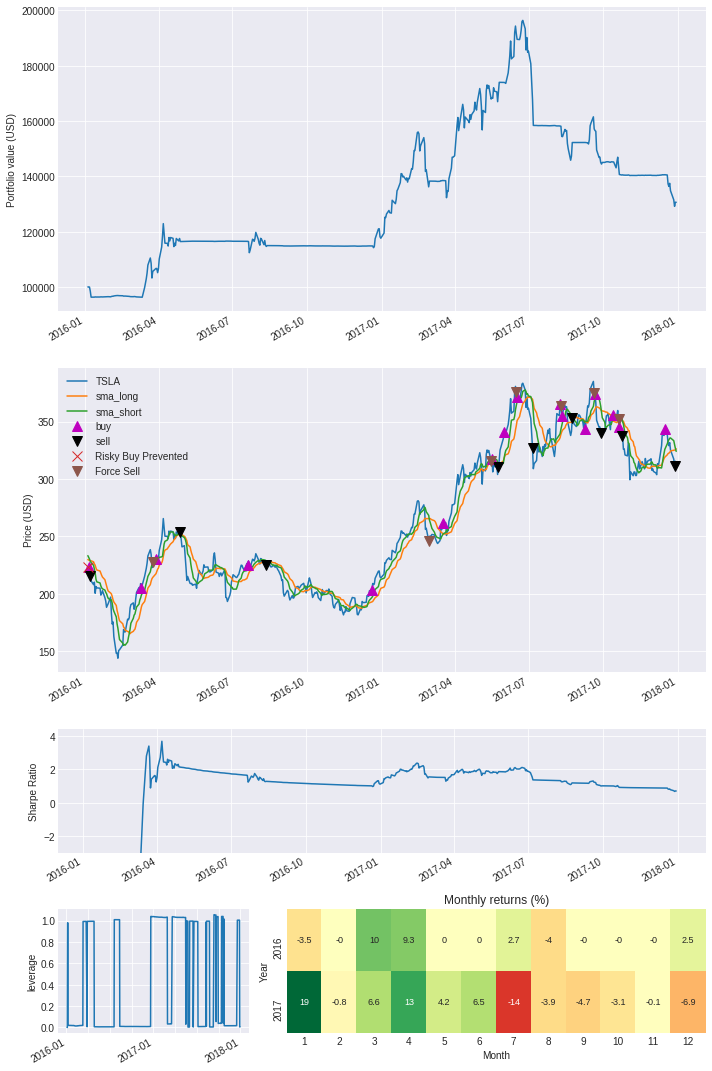

In [8]:
results = run_algorithm(env['test']['start_time'], env['test']['end_time'],
                        initialize=initialize,capital_base=env['capital'], analyze=analyze)
results.to_pickle("results/ESMA_GMM.pickle")

## Conclusion
Although the result is still relatively bad! However, There is an improvement in both strategies. SMA has a better improvement especially when we look at the monthly returns compared to the same strategies without the GMM risk manager. 

This can indicate that GMM as a risk manager can be used with other strategies to reduce the risk. It would be interesting to see the result when combined with a good strategy.  